In [189]:
# import pandas and gurobi
import pandas as pd
from gurobipy import *
import numpy as np


In [190]:
# read in csv
r = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/model_return_predictions_2019.csv")
ar = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/monthly_returns_2019.csv")
s = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/sectors_2019.csv")
p = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/monthly_prices_2019.csv")
cor = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/corr_2019.csv")
cov = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/cov_2019.csv")
vol = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/monthly_volume_2019.csv")
cov = cov.drop(columns=['Unnamed: 0'])
s = s.drop(columns=['Symbol'])
p = p.drop(columns=['Date'])
r = r.drop(columns=['Date'])
ar = ar.drop(columns=['Date'])
cor = cor.drop(columns=['Unnamed: 0'])
vol = vol.drop(columns=['Date'])
# cast vol to float
vol = vol.astype(float)

In [197]:
# make model
stocks = len(s)
k = 10
T = 12
transaction = np.zeros(T)
# total = array of size 12
total = np.zeros(T+1)
total[0] = 5000
portfolio = np.zeros((stocks, T))
inventoryT0 = np.zeros((stocks))
inventoryT1 = np.zeros((stocks))
obj = np.zeros(T+1)
obj2 = np.zeros(T+1)

for t in range(T): 
    m = Model('portfolio')

    # Add matrix variable for the stocks
    x = m.addMVar(stocks, lb = 0, ub = .2) 
    z = m.addVars(stocks, vtype=GRB.BINARY, name="z")
    b = m.addVars(stocks, vtype=GRB.INTEGER, lb=0, name="x")
    # defUnc
    #defUnc = m.addVars(stocks, vtype=GRB.BINARY, name="defUnc")
    

    # Objective is to minimize risk (squared).  This is modeled using the
    # covariance matrix, which measures the historical correlation between stocks
    portfolio_risk = x @ np.matrix(cov) @ x
    ret = np.matrix(r.iloc[t]) @ x
    m.setObjective(ret, GRB.MAXIMIZE)
    # Fix budget with a constraint
    m.addConstr(x.sum() == 1, 'budget')
    # return is at least 0.1
    m.addConstr(portfolio_risk <= 0.05, 'return')
    m.addConstrs((x[i] <= z[i] for i in range(stocks)), "w<=z")
    #m.addConstrs((b[i] >= z[i]*5 for i in range(stocks)), "b<=5")
    m.addConstrs((10000*x[i] >= z[i] for i in range(stocks)), "w>=z")
    m.addConstr(quicksum(z[i] for i in range(stocks)) >= k, "k")
    m.addConstr(quicksum(b[i]*p.iloc[t,i] for i in range(stocks)) <= total[t], "budget")
    m.addConstrs((b[i] >= z[i] for i in range(stocks)), "x>=fvfav")
    m.addConstrs((x[i] == (b[i]*p.iloc[t,i])/(total[t]) for i in range(stocks)), "w")
    m.addConstrs((quicksum(z[i]*s.iloc[i,j] for i in range(stocks)) <= 4 for j in range(len(s.columns))), "sector")
    # difference between b[i] and inventoryT1[i] is less than v[i,t]
    m.addConstrs((b[i] - inventoryT1[i] <= .05*vol.iloc[t,i] for i in range(stocks)), "v")
    # z*.05 <= x
    m.addConstrs((z[i]*.05 <= x[i] for i in range(stocks)), "z")
    m.Params.MIPGap = 0.01

    # stocks we buy must have a corr[i,j] < 0.5
    m.addConstrs((z[i] + z[j] <= 1 for i in range(stocks) for j in range(stocks) if i != j and abs(cor.iloc[i,j]) > 0.3), "corr")

    m.optimize()
    
    obj[t] = portfolio_risk.getValue()
    obj2[t] = ret.getValue()
    if t == 0:
       #make inventoryT0 equal to all zeros
        inventoryT0 = np.zeros((stocks))
    else:
        inventoryT0 = inventoryT1.copy()
    # print optimal x
    for v in m.getVars():
        if v.varName[0] == 'x':
            inventoryT1[int(v.varName.replace("x[","").replace("]",""))] = v.x
            total[t+1] += v.x*p.iloc[t+1,int(v.varName.replace("x[","").replace("]",""))]
            if (abs(inventoryT0[int(v.varName.replace("x[","").replace("]",""))]-inventoryT1[int(v.varName.replace("x[","").replace("]",""))])) > 0:
                total[t+1] -= (8.9)
                transaction[t] += 1
                # avg transaction cost
            
    portfolio[:,t] = np.array([v.x for v in m.getVars() if v.varName[0] == 'C'])
    

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 95864 rows, 1431 columns and 193131 nonzeros
Model fingerprint: 0x59a73951
Model has 1 quadratic constraint
Variable types: 477 continuous, 954 integer (477 binary)
Coefficient statistics:
  Matrix range     [9e-04, 1e+04]
  QMatrix range    [1e-08, 9e-02]
  Objective range  [2e-06, 9e-02]
  Bounds range     [2e-01, 1e+00]
  RHS range        [1e+00, 7e+06]
  QRHS range       [5e-02, 5e-02]
Presolve removed 91488 rows and 318 columns
Presolve time: 1.45s
Presolved: 4376 rows, 1113 columns, 94210 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 167 continuous, 946 integer (474 binary)

Root relaxation: objective 5.468825e-02, 865 iterations, 0.07 seconds (0.15 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth 

In [199]:
#loop through total and print out the total value of the portfolio at each time step
for i in range(len(total)):
    if i == 0:
        print("Initial value: " + str(total[i]))
    else:
        print("Total value of portfolio at the end of month " + ": " + str(total[i]), " Risk: " + str(obj[i]), " Return: " + str(obj2[i]))

Initial value: 5000.0
Total value of portfolio at the end of month : 6057.132951736451  Risk: 0.007253824207836233  Return: 0.05388545115771213
Total value of portfolio at the end of month : 6261.203673934938  Risk: 0.007692875770999693  Return: 0.054391035858011166
Total value of portfolio at the end of month : 6336.941900634766  Risk: 0.007591262588361809  Return: 0.06022925304137107
Total value of portfolio at the end of month : 6471.33227519989  Risk: 0.007822424463528184  Return: 0.059988289964480156
Total value of portfolio at the end of month : 6700.471790728471  Risk: 0.007631179996975684  Return: 0.060589285041553524
Total value of portfolio at the end of month : 7253.007818984986  Risk: 0.007967945257518004  Return: 0.0689135296679571
Total value of portfolio at the end of month : 7990.510505294803  Risk: 0.007570309445298342  Return: 0.06810509867824215
Total value of portfolio at the end of month : 8183.456992530824  Risk: 0.008002138746017703  Return: 0.06853827145507879
T

In [171]:
# mean of r over rows
(total[-1]-100000)/100000

0.8027262581520085

In [200]:
import plotly.graph_objects as go

result_returns = np.zeros(T+1)
for i in range(1,len(total)):
    result_returns[i] = (total[i]-total[i-1])/total[i-1]
# graph in plotly - plt.plot(np.cumprod(1+result_returns)-1)
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(0,T+1), y=np.cumprod(1+result_returns[1:])-1, name='Portfolio'))
fig.add_trace(go.Scatter(x=np.arange(0,T+1), y=np.cumprod(1+ar.iloc[1:,:].mean(axis=1))-1, name='S&P 500'))
# labels
fig.update_layout(title='Our Portfolio\'s Returns compared to S&P 500', xaxis_title='Month', yaxis_title='Returns')
fig.show()

In [1]:
(.83-.33)/.33

1.515151515151515

In [160]:
# ploty transactions over time
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(0,T), y=transaction, name='Transactions'))
# labels
fig.update_layout(title='Transactions over Time', xaxis_title='Month', yaxis_title='Transactions')
fig.show()

Text(0, 0.5, 'Percentage of portfolio')

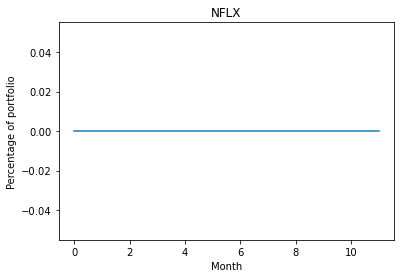

In [131]:
import matplotlib.pyplot as plt
stockPlot = r.columns.get_loc("NFLX")
plt.plot(portfolio[stockPlot,:])
# TITLE  = stock name
plt.title(p.columns[stockPlot])
plt.xlabel("Month")
plt.ylabel("Percentage of portfolio")

In [201]:
# graph every stock in portfolio on same graph in plotly
import plotly.graph_objects as go
fig = go.Figure()
for i in range(len(portfolio)):
    fig.add_trace(go.Scatter(x=np.arange(0,12), y=portfolio[i,:], name=p.columns[i]))
fig.show()